In [1]:
!pip uninstall fitz -y
!pip uninstall PyMuPDF -y
!pip install PyMuPDF

In [1]:
import torch
import os
from pathlib import Path
import warnings
from tqdm import tqdm

from razdel import sentenize
import fitz
import re

import pandas as pd
import seaborn as sns

warnings.filterwarnings('ignore')

In [2]:
class PDFDataset(torch.utils.data.Dataset):
    
    def check_pdfs(self):
        self.pdfs = []

        assert Path(f"{self.data_dir}/spbu/pdf").is_dir() == True

        for path in os.listdir(f"{self.data_dir}/spbu/pdf"):
            if os.path.isfile(os.path.join(f"{self.data_dir}/spbu/pdf", path)):
                self.pdfs.append(path)
    
    def __init__(self, data_dir='data'):
        self.data_dir = data_dir
        self.check_pdfs()
    
    def __getitem__(self, idx):
        return {'name': self.pdfs[idx], "path": f"{self.data_dir}/spbu/pdf/{self.pdfs[idx]}"} 
    
    def __len__(self):
        return len(self.pdfs)
    
    def read_pdf(self, idx):
        return open(os.path.join(f"{self.data_dir}/spbu/pdf", self.pdfs[idx]), 'rb')
    

# defects

- специальные символы( <>=+*●}{/∈≤≥Σ тп) resolved
- повторяющиеся пробелы склеить resolved
- процентное содержание буков dont need
- пустые строки убрать resolved
- удалять предложения если в них есть слова введения, оглавление todo
- delete if https: in text resolved
- re.sub("S- ", "") resolved
- replace unix chars todo
- counter по символам, посмотреть всякое говно

In [3]:
dataset = PDFDataset("data")


In [4]:
ruABC = "ёйцукенгшщзхъфывапролджэячсмитьбюЁЙЦУКЕНГШЩЗХЪФЫВАПРОЛДЖЭЯЧСМИТЬБЮ"
enABC = "qwertyuiopasdfghjklzxcvbnmQWERTYUIOPASDFGHJKLZXCVBNM"
nums =  r'1234567890,.-)([]:@%№$" '
acceptable_chars = ruABC + enABC + nums

In [5]:
def convert_case(match_obj):
        if match_obj.group(1) is not None:
            return match_obj.group(1)

class PDFParser:
    
    SPECIAL_CHARS = "#^&*+_=<✓α𝑎>/\≡≡Σ∑∈●}{≤≥�åðÿæπ"
    NUMBERS = ("1","2", "3","4" ,"5" ,"6" ,"7" ,"8" ,"9")
    ACCEPTABLE_CHARS = acceptable_chars
    REPLACEMENT_DICT = {
        "»": r'"',
        "«": r'"',
        "”": r'"',
        "“": r'"',
        "—": r'-',
        "–": r'-'
    }
    
    def __init__(self):
        return
    
    @staticmethod
    def convert_case(match_obj):
        if match_obj.group(1) is not None:
            return match_obj.group(1)
    
    @staticmethod
    def delete_repeating_whitespaces(sent):
        return re.sub(' +', ' ', sent)
    
    @staticmethod
    def delete_unicode(sent):
        sent = re.sub('\xad', ' ', sent)
        return sent.encode("utf-8", "ignore").decode()

    @staticmethod
    def replace_hyphenation(sent):
        return re.sub("(\S)- ", convert_case, sent)
    
    
    def replace_chars(self, sent):
        for key in self.REPLACEMENT_DICT:
            sent = sent.replace(key, self.REPLACEMENT_DICT[key])
        return sent
    
    
    def mark_blocks(self):
        for block in self.blocks:
            if 84 < block['bbox'][0] < 86:
                block['type'] = "text"
            if block['lines'][0]['spans'][0]['font'] == 'CMUSerif-Bold':
                block['type'] = 'title'
            
    def blocks_to_text(self):
        textlines = [] 
        for block in self.blocks:
            block_textlines = []
            for line in block['lines']:
                for span in line['spans']:
                    block_textlines.append(span['text'])
            if not block_textlines[0].startswith("["):
                textlines += block_textlines
        return " ".join(textlines)
    
    def text_to_sents(self, text):
        
        sents = [sent.text for sent in list(sentenize(text))]
        
        
        
        sents = list(filter(lambda x: not any (c in self.SPECIAL_CHARS for c in x), sents))
        sents = list(filter(lambda x: not x.startswith(self.NUMBERS), sents))
        sents = list(filter(lambda x: not "https:" in x, sents))
        sents = list(filter(lambda x: not re.search(r"[1-9]\.", x), sents))
        
        sents = [self.replace_chars(sent) for sent in sents] 
        sents = [self.delete_repeating_whitespaces(sent) for sent in sents]
        sents = [self.replace_hyphenation(sent) for sent in sents]
        sents = [self.delete_unicode(sent) for sent in sents]
        
        sents = list(filter(lambda x: all (c in self.ACCEPTABLE_CHARS for c in x), sents))
        sents = list(filter(lambda x: len(x) > 21, sents))
        sents = list(filter(lambda x: len(x) < 512, sents))
        
        return sents 
    
    def get_sentences(self, doc_path):
        try:
            doc = fitz.open(doc_path)
        except:
            return []
        
        self.blocks = []
        
        for page in doc:
            self.blocks += page.get_text("dict", flags=16)['blocks']

        self.mark_blocks()
        self.blocks = list(filter(lambda x: x['type'] == 'text', self.blocks))
        
        return self.text_to_sents(self.blocks_to_text())

In [6]:
parser = PDFParser()

In [7]:
sents = []
for pdf in tqdm(dataset):
    sents += parser.get_sentences(pdf['path'])

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [00:33<00:00,  8.26it/s]


In [ ]:
len(sents)

In [68]:
for sent in sents[::50]:
    print(sent)

Заключение Список литературы 35 Введение Языки программирования - область, которая активно развивается на протяжении всей истории развития IT, начиная с 50 х годов прошлого века.
Необходимо определить, в каком файле какие написанные на РуСи функции могут использоваться.
Однако действительно переиспользованы могут быть не все обнаруженные фрагменты, так как похожие тексты не всегда означают одно и то же.
Первые три алгоритма были взяты из статьи [28], расстояние Левенштейна добавлено в силу его распространённости.
В случае составных тегов добавляются следующие действия.
Немного хуже качество у LEV с сегментацией, ещё хуже у COS.
[13] При кластеризации сегментов изучается сходство между ними, и строится иерархия кластеров [9].
Поэтому для данной задачи был использован модифицированный детектор речевой активности, который используется в сервисе Integrator (Рис. 6).
Hadoop на данный момент представляет набор подпроектов Apache Software Foundation, среди которых находятся Hadoop MapReduce и

Данная операция атомарно выполняет чтение значения разделяемой переменной, сравнивает её с ожидаемым значением (второй аргумент CAS).
В первую очередь, чтобы проверить, что интерпретатор корректно работает со всеми поддержанными моделями памяти, интерпретатор был протестирован на наборе "лакмусовых" тестов.
В данной работе мы сфокусировались на разработке и апробации алгоритмов для сенсора безопасного движения.
В работе [ 14 ] авторы представили способ определения рельефа дорожной поверхности без использования карты глубины.
Листинг 1 Сегментация плотной карты диспаритета согласно модели Stixel World Вход: Карта диспаритета, ширина стикселя Выход: Множество стикселей, описывающих карту глубины согласно модели Stixel World Рис. 6: Сегментация изображения согласно модели Stixel World.
Отделить один случай от другого возможно только для объектов, перекрытых объектами, присутствующими в разметке.
Для этой цели используется имитационная среда Simulink в пакете прикладных программ Matlab.
То

Важно не только задать всю последовательность действий, но и описать реакцию на сбойные ситуации, так как, например, из-за случайного мусора или неровностей поверхности робот может сбиться с пути или упасть, что способно вызвать нарушение корректной работы системы или даже поломку перевозимого груза.
Заметим, что хранение всей информации может быть избыточным и неэффективным, поэтому в качестве связей между элементами используется только id.
Использование контрактов выгодны в ситуациях, когда классические средства обеспечения выполнения контракта слишком дороги или стороны не имеют доступа к общему арбитру или юридической системе.
В качестве источника данных об уязвимостям был выбран вывод анализатора Mythril Classiс, как самого популярного и постоянно развивающегося проекта.
Существуют две схемы разработки СПП: проактивная (снизу вверх) [6] и реактивная (сверху вниз) [7].
В таком случае, если придерживаться определения, технический писатель сможет с помощью описываемой в этом разделе 

In [69]:
df = pd.DataFrame({"text": sents})
    df.to_csv("data/sents/spbu_sents_temp_2.csv", encoding='utf-8')

# find anomalies

In [2]:
import pandas as pd
import seaborn as sns


In [3]:
df = pd.read_csv("data/sents/spbu_sents_temp_2.csv")

In [4]:
df['sent_len'] = df.text.apply(len)

In [5]:
df['text_lower'] = df.text.apply(lambda x: x.lower())

In [6]:
df.describe()

,Unnamed: 0,sent_len
count,84960.000000,84960.000000
mean,42479.500000,137.709193
std,24525.983772,70.690341
min,0.000000,11.000000
25%,21239.750000,87.000000
50%,42479.500000,124.000000
75%,63719.250000,173.000000
max,84959.000000,511.000000


<AxesSubplot:xlabel='sent_len', ylabel='Count'>

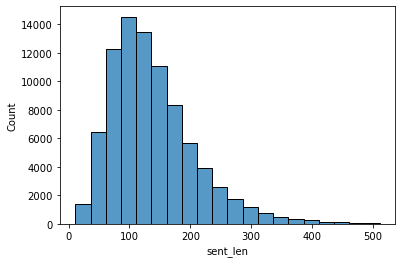

In [7]:
sns.histplot(data=df, x='sent_len', bins=20)

In [8]:
full_text = " ".join(list(df.text_lower))

In [9]:
from collections import Counter

In [19]:
ruABC = "ёйцукенгшщзхъфывапролджэячсмитьбюЁЙЦУКЕНГШЩЗХЪФЫВАПРОЛДЖЭЯЧСМИТЬБЮ"
enABC = "qwertyuiopasdfghjklzxcvbnmQWERTYUIOPASDFGHJKLZXCVBNM"
nums =  r'1234567890,.-)([]:@%№$" '
acceptable_chars = ruABC + enABC + nums

In [23]:
chars = [char[0] for char in Counter(full_text).most_common(1000)]

In [26]:
unacceptable_chars = [char for char in chars if char not in acceptable_chars]

In [20]:
replacement_dict = {
    "»": r'"',
    "«": r'"',
    "”": r'"',
    "“": r'"',
    "—": r'-',
    "–": r'-'
}

In [11]:
Counter(full_text).most_common(1000)

[(' ', 1516394),
 ('о', 1009983),
 ('е', 791938),
 ('и', 742764),
 ('а', 731059),
 ('т', 635094),
 ('н', 622053),
 ('р', 506574),
 ('с', 490637),
 ('в', 388665),
 ('л', 368041),
 ('м', 318670),
 ('к', 296121),
 ('п', 283278),
 ('д', 278024),
 ('я', 221601),
 ('ы', 202449),
 ('у', 191528),
 ('з', 182660),
 ('б', 153840),
 ('ь', 139734),
 (',', 117070),
 ('ч', 116806),
 ('г', 115477),
 ('.', 111911),
 ('й', 111068),
 ('х', 102625),
 ('ж', 73436),
 ('ю', 63956),
 ('ц', 62252),
 ('e', 57036),
 ('ф', 44432),
 ('a', 43596),
 ('t', 42740),
 ('щ', 41259),
 ('i', 39934),
 ('r', 37919),
 ('o', 37893),
 ('ш', 36591),
 ('s', 35878),
 ('n', 34224),
 ('э', 29373),
 ('l', 26909),
 ('c', 25138),
 ('-', 22461),
 ('p', 21293),
 ('d', 19833),
 ('m', 19209),
 ('u', 15093),
 ('g', 12978),
 ('h', 12774),
 (')', 12246),
 ('(', 12208),
 ('f', 11490),
 ('1', 11245),
 ('b', 10374),
 ('[', 9876),
 (']', 9865),
 ('"', 8577),
 ('v', 8512),
 (':', 8355),
 ('2', 7449),
 ('0', 7048),
 ('y', 6750),
 ('ё', 6512),
 ('k'